In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import pyfolio

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Explore (provided) Dataset

<Figure size 432x288 with 0 Axes>

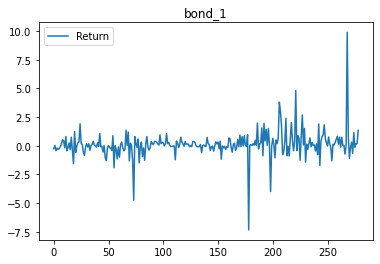

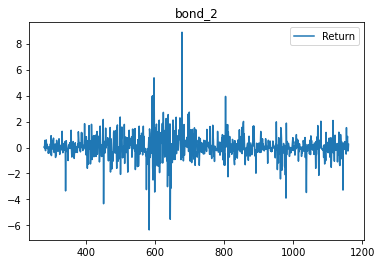

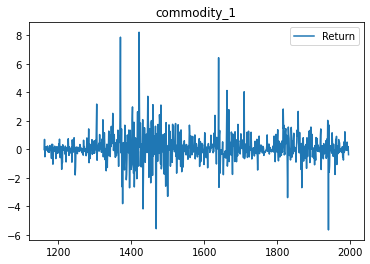

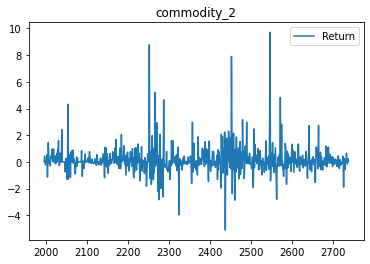

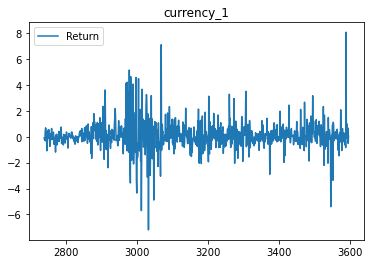

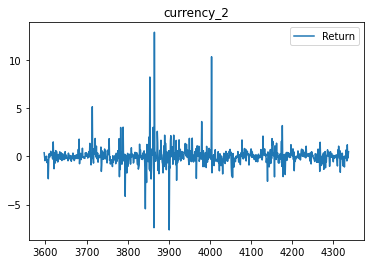

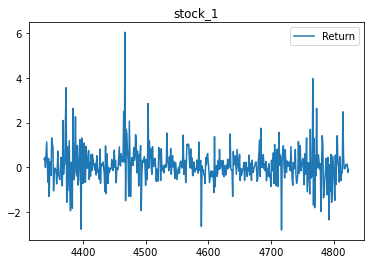

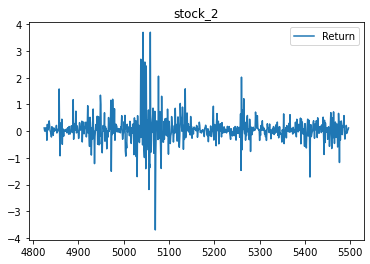

In [35]:
plt.figure()
with pd.plotting.plot_params.use("x_compat", True):
    for market in ml_train_raw.Market.unique():
        ml_train_raw[ml_train_raw['Market'] == market].plot(title=market)
#         ml_train_raw[ml_train_raw['Market'] == 'bond_2'].plot(color='g')

In [ ]:
ml_train_raw[ml_train_raw['Market'] == 'bond_1'].plot(x='Trade_date', y='Return')

In [134]:
ml_train_raw.isnull().values.any()

False

In [21]:
print(ml_train_raw[ml_train_raw['Market'] == 'bond_1'].Trade_date.iloc[0])
print(ml_train_raw[ml_train_raw['Market'] == 'bond_1'].Trade_date.iloc[-1])

2012-11-07
2015-12-29


In [23]:
for market in ml_train_raw.Market.unique():
    print('{}.shape: {}'.format(market, ml_train_raw[ml_train_raw['Market'] == market].shape))
    print('{} first date: {}'.format(market, ml_train_raw[ml_train_raw['Market'] == market].Trade_date.iloc[0]))
    print('{} last date: {}'.format(market, ml_train_raw[ml_train_raw['Market'] == market].Trade_date.iloc[-1]))
    print()

bond_1.shape: (279, 4)
bond_1 first date: 2012-11-07
bond_1 last date: 2015-12-29

bond_2.shape: (882, 4)
bond_2 first date: 2006-01-10
bond_2 last date: 2015-12-29

commodity_1.shape: (835, 4)
commodity_1 first date: 2006-01-06
commodity_1 last date: 2015-12-31

commodity_2.shape: (742, 4)
commodity_2 first date: 2006-01-05
commodity_2 last date: 2015-12-21

currency_1.shape: (859, 4)
currency_1 first date: 2006-01-04
currency_1 last date: 2015-12-31

currency_2.shape: (741, 4)
currency_2 first date: 2006-01-06
currency_2 last date: 2015-12-18

stock_1.shape: (487, 4)
stock_1 first date: 2010-01-12
stock_1 last date: 2015-12-29

stock_2.shape: (672, 4)
stock_2 first date: 2006-01-20
stock_2 last date: 2015-12-29



In [12]:
ml_train = ml_train_raw.drop('Trade_time', axis=1)

merged_stocks = ml_train[ml_train['Market'] == 'stock_1'].merge(ml_train[ml_train['Market'] == 'stock_2'], on='Trade_date', suffixes=['_stock1', '_stock2'])
merged_bonds = ml_train[ml_train['Market'] == 'bond_1'].merge(ml_train[ml_train['Market'] == 'bond_2'], on='Trade_date', suffixes=['_bond1', '_bond2'])
merged_currencies = ml_train[ml_train['Market'] == 'currency_1'].merge(ml_train[ml_train['Market'] == 'currency_2'], on='Trade_date', suffixes=['_currency1', '_currency2'])
merged_commodities = ml_train[ml_train['Market'] == 'commodity_1'].merge(ml_train[ml_train['Market'] == 'commodity_2'], on='Trade_date', suffixes=['_commodity1', '_commodity2'])

merged_stocks = merged_stocks.drop(['Market_stock1', 'Market_stock2'], axis=1)
merged_bonds = merged_bonds.drop(['Market_bond1', 'Market_bond2'], axis=1)
merged_currencies = merged_currencies.drop(['Market_currency1', 'Market_currency2'], axis=1)
merged_commodities = merged_commodities.drop(['Market_commodity1', 'Market_commodity2'], axis=1)


In [90]:
# merged = merged_data.drop(['Market_stock1', 'Market_stock2'], axis=1)
merged_bonds.columns

Index(['Trade_date', 'Return_bond1', 'Return_bond2'], dtype='object')

<AxesSubplot:xlabel='Return_commodity1', ylabel='Return_commodity2'>

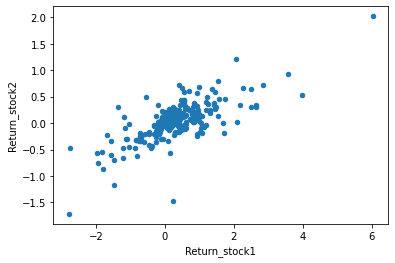

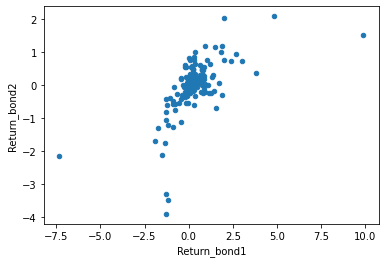

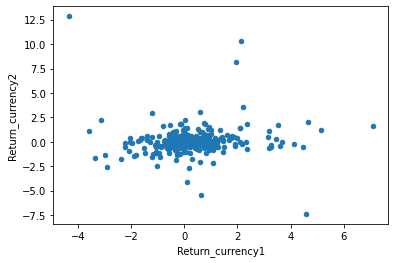

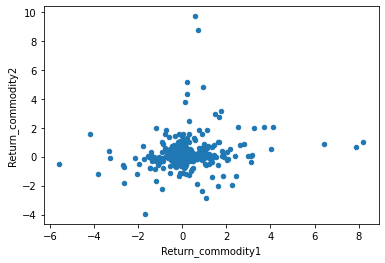

In [91]:
merged_stocks.plot.scatter(x='Return_stock1', y='Return_stock2')
merged_bonds.plot.scatter(x='Return_bond1', y='Return_bond2')
merged_currencies.plot.scatter(x='Return_currency1', y='Return_currency2')
merged_commodities.plot.scatter(x='Return_commodity1', y='Return_commodity2')

In [95]:
merged_stocks.corr()

Return_stock1  Return_stock2
Return_stock1       1.000000       0.728933
Return_stock2       0.728933       1.000000

In [94]:
merged_bonds.corr()

Return_bond1  Return_bond2
Return_bond1      1.000000      0.616627
Return_bond2      0.616627      1.000000

In [92]:
merged_currencies.corr()

Return_currency1  Return_currency2
Return_currency1          1.000000          0.038416
Return_currency2          0.038416          1.000000

In [93]:
merged_commodities.corr()

Return_commodity1  Return_commodity2
Return_commodity1           1.000000           0.161139
Return_commodity2           0.161139           1.000000

# Create a Tear Sheet

In [3]:
def process_returns(data):
    df = data.copy()
    df = df.fillna(0.0)
    if 'action' in df.columns:
        df['action_adj_returns'] = df.Return * df.action
    else:
        df['action_adj_returns'] = df.Return
    df.loc[df.index[0], 'action_adj_returns'] = 1.0
    df['cumulated_returns'] = df.action_adj_returns.cumsum()
    df['cumulated_returns_pct'] = df['cumulated_returns'].pct_change(1)
    df = df.fillna(0.0)
    return df

### Bond1

In [4]:
bond1_indicators_filename = 'Data/ml_bond1_indicators.pkl'
train_filename = 'Data/train_bond1_prediction.pkl'
test_filename = 'Data/test_bond1_prediction.pkl'
# bond = load_given_data(bond_filename)
bond1_flattened_indicators = pd.read_pickle(bond1_indicators_filename)
bond1_flattened_indicators = bond1_flattened_indicators.set_index('date')
bond1_flattened_indicators = bond1_flattened_indicators.drop(bond1_flattened_indicators.columns[1:], axis=1)
bond1 = process_returns(bond1_flattened_indicators)
train_returns = pd.read_pickle(train_filename)
test_returns = pd.read_pickle(test_filename)
returns = pd.concat([train_returns, test_returns], axis=0)
returns = returns.rename(columns={'return': 'Return'})
returns = process_returns(returns)
bond1 = process_returns(bond1_flattened_indicators)

In [9]:
bond1_sharpe_ratio = returns.cumulated_returns_pct.mean() / returns.cumulated_returns_pct.std()
annualised_bond1_sharpe_ratio = 252**0.5 * bond1_sharpe_ratio

In [11]:
print('bond1_sharpe_ratio: {}'.format(bond1_sharpe_ratio))
print('annualised_bond1_sharpe_ratio: {}'.format(annualised_bond1_sharpe_ratio))


bond1_sharpe_ratio: 0.13954789200268822
annualised_bond1_sharpe_ratio: 2.2152541093344738


Entire data start date: 2006-01-04
Entire data end date: 2021-03-23
Backtest months: 180


/Users/stevenbattilana/opt/anaconda3/envs/algothon21/lib/python3.8/site-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/stevenbattilana/opt/anaconda3/envs/algothon21/lib/python3.8/site-packages/empyrical/stats.py:1527: RuntimeWarning: divide by zero encountered in double_scalars
  return np.abs(np.percentile(returns, 95)) / \


Backtest
Annual return           49.4%
Cumulative returns   42327.8%
Annual volatility       18.8%
Sharpe ratio             2.22
Calmar ratio              NaN
Stability                0.94
Max drawdown             0.0%
Omega ratio               NaN
Sortino ratio             inf
Skew                    23.82
Kurtosis               723.37
Tail ratio                inf
Daily value at risk     -2.2%
Alpha                    0.51
Beta                      0.0

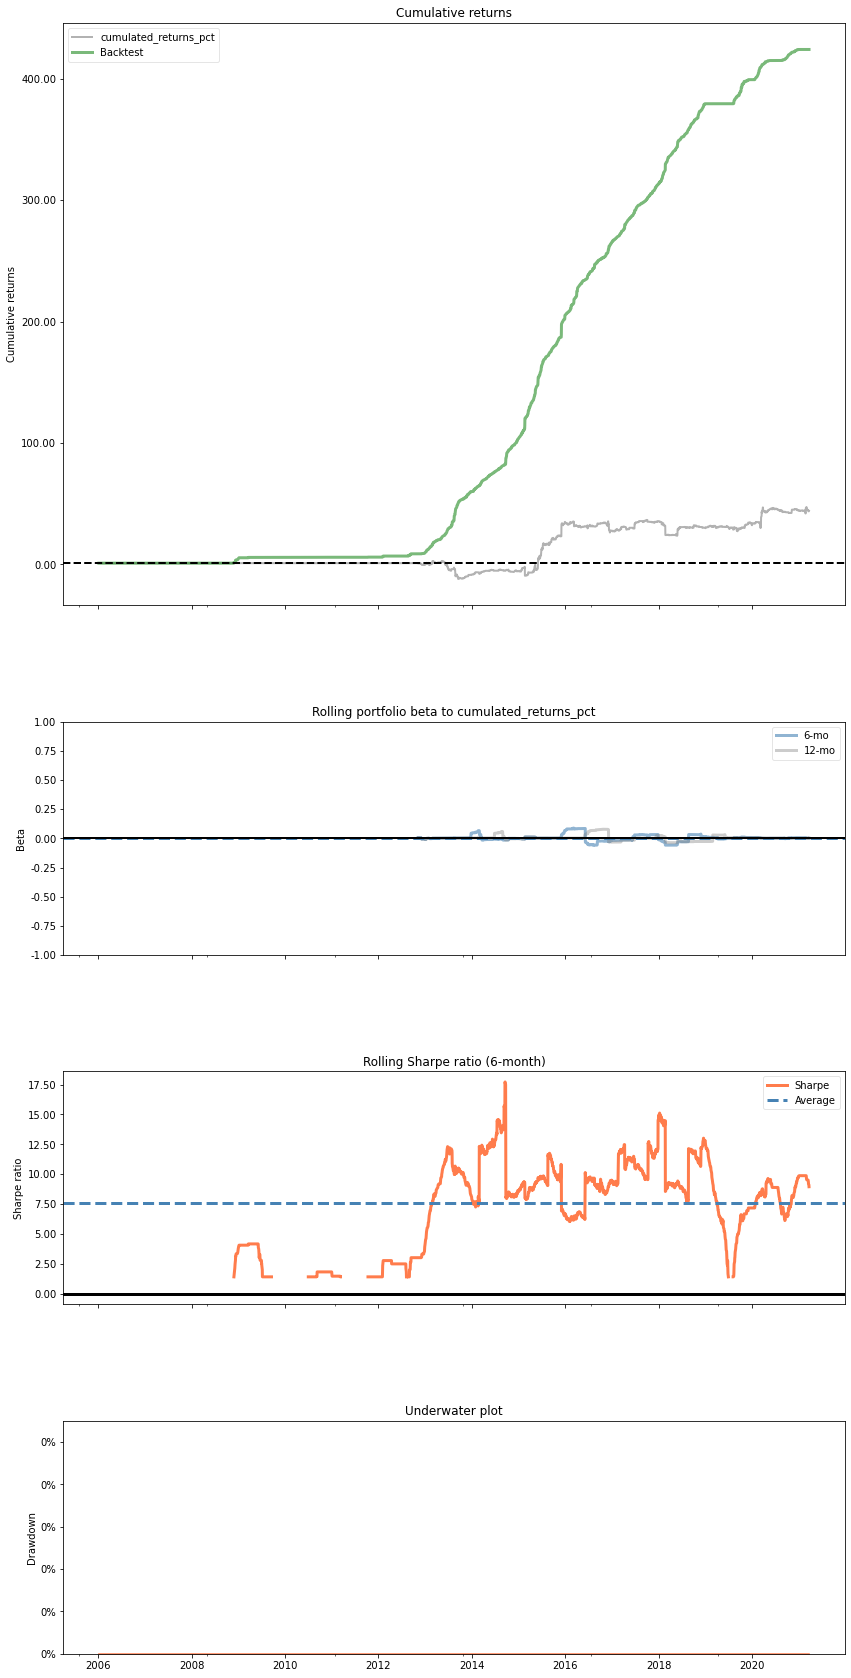

In [5]:
pyfolio.create_simple_tear_sheet(returns.cumulated_returns_pct, benchmark_rets=bond1.cumulated_returns_pct)
